filename: refactor_span_level_data_collator.ipynb
    

In [1]:
%load_ext line_profiler
%load_ext memory_profiler


In [2]:
import sys
sys.path.append('../../thai2transformers')

import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [3]:
import torch
import transformers
from transformers import AutoTokenizer , DataCollatorForLanguageModeling
import math
from typing import List, Dict, Union, Optional, Tuple, Any
from dataclasses import dataclass
import numpy as np
import pandas as pd
import torch
import random
from bisect import bisect
from transformers.data.data_collator import DataCollatorForLanguageModeling, _collate_batch, tolist
from transformers.tokenization_utils_base import BatchEncoding, PreTrainedTokenizerBase

import glob, os
from torch.utils.data.dataloader import DataLoader

from torch.utils.data.sampler import RandomSampler, SequentialSampler


from thai2transformers.datasets import MLMDataset

In [4]:
transformers.__version__

'4.6.1'

In [5]:
tokenizer = AutoTokenizer.from_pretrained('airesearchth/wangchanberta-base-wiki-20210520-spm')

In [108]:
DUMMY_TRAIN_DATA_PATH = '../../dataset/split/thwiki-for-ddp_6.11.2020/train_dummy/'
TRAIN_DATA_PATH = '../../dataset/split/thwiki-for-ddp_6.11.2020/train_debug/'

In [7]:
%%time 

train_dataset = MLMDataset(tokenizer,
                           TRAIN_DATA_PATH,
                           510)


[INFO] Build features (parallel).

[INFO] Start groupping results.
[INFO] Done.
CPU times: user 271 ms, sys: 72.6 ms, total: 344 ms
Wall time: 2.25 s


In [109]:
train_dataset_dummy = MLMDataset(tokenizer,
                           DUMMY_TRAIN_DATA_PATH,
                           510)


[INFO] Build features (parallel).

[INFO] Start groupping results.
[INFO] Done.


In [110]:
len(train_dataset), len(train_dataset_dummy)

(20000, 20080)

In [111]:
train_dataset[0], train_dataset_dummy[0]

(tensor([    5,     8,  3060,  3060,   502,  3501,   299,    15, 19498, 19498,
           502,  3501,   299,  1328,   502,  3501, 10905, 15141,    18,   502,
          3501,   299,  6225,   592,  5127, 13132,    19, 16440,   502,  3501,
           299,   651,   537,  2751, 12487,   502,  3501,   299,   779, 13579,
          1173,  3419, 17624,   429,   502,  3501,   299,    25, 17624,   249,
           557,  6520,    19,   502,  3501,   299,  3419,  3678,    47,  7396,
            11,  5773,    32,  3423,   259,   502,  3501,   299, 13579,    54,
          5127,    45,  8085,    42,  8361, 18042,  2315,    12,  6885,   502,
          3501,   299,    23,   530,   445, 17624,  2984,  9040,  9248,   502,
          3501,   299,    11,  5470,   475,     9,    89,   259,   502,  3501,
           299,    28,  5099,   825,   475,     9,   502,  3501,   299, 13934,
            27,  1204,  1045,     8,     6]),
 tensor([   5,    8,  502, 3501,  299,  502, 3501,  299,  502, 3501,  299,  502,
    

In [10]:
import math
from typing import List, Dict, Union, Optional, Tuple, Any
from dataclasses import dataclass
import numpy as np
import torch
import random
from bisect import bisect
from transformers.data.data_collator import DataCollatorForLanguageModeling, _collate_batch, tolist
from transformers.tokenization_utils_base import BatchEncoding, PreTrainedTokenizerBase

SPECIAL_TOKEN_NAMES = ['bos_token', 'eos_token', 'sep_token', 'cls_token', 'pad_token']

@dataclass
class DataCollatorForSpanLevelMask(DataCollatorForLanguageModeling):
    """
    Data collator used for span-level masked language modeling
     
    adapted from NGramMaskGenerator class
    
    https://github.com/microsoft/DeBERTa/blob/11fa20141d9700ba2272b38f2d5fce33d981438b/DeBERTa/apps/tasks/mlm_task.py#L36
    and
    https://github.com/zihangdai/xlnet/blob/0b642d14dd8aec7f1e1ecbf7d6942d5faa6be1f0/data_utils.py

    """
    tokenizer: PreTrainedTokenizerBase
    mlm: bool = True
    mlm_probability: float = 0.15
    max_gram: int = 3
    keep_prob: float = 0.0
    mask_prob: float = 1.0
    max_preds_per_seq: int = None
    max_seq_len: int = 510
    pad_to_multiple_of: Optional[int] = None

    def __new__(cls, tokenizer, mlm, mlm_probability, pad_to_multiple_of, *args, **kwargs):

        obj = object.__new__(cls)
        DataCollatorForLanguageModeling.__init__(obj, tokenizer=tokenizer, mlm=mlm,
                                                 mlm_probability=mlm_probability,
                                                 pad_to_multiple_of=pad_to_multiple_of)

        return obj
    

    def __post_init__(self, *args, **kwargs):

        assert self.mask_prob + self.keep_prob <= 1, \
            f'The prob of using [MASK]({self.mask_prob}) and the prob of using original token({self.keep_prob}) should between [0,1]'

        if self.max_preds_per_seq is None:
            self.max_preds_per_seq = math.ceil(self.max_seq_len * self.mlm_probability / 10) * 10
            self.mask_window = int(1 / self.mlm_probability) # make ngrams per window sized context
        self.vocab_words = list(self.tokenizer.get_vocab().keys())
        self.vocab_mapping = self.tokenizer.get_vocab()
        
        self.special_tokens = [ self.tokenizer.special_tokens_map[special_token_name] \
                                for special_token_name in SPECIAL_TOKEN_NAMES]
    
        self.ngrams = np.arange(1, self.max_gram + 1, dtype=np.int64)
        _pvals = 1. / np.arange(1, self.max_gram + 1)
        self.pvals = _pvals / _pvals.sum(keepdims=True)

    def _choice(self, rng, data, p):
        cul = np.cumsum(p)
        x = rng.random()*cul[-1]
        id = bisect(cul, x)
        return data[id]

    def _per_token_mask(self, idx, tokens, rng, mask_prob, keep_prob):
        label = tokens[idx]
        mask = self.tokenizer.mask_token
        rand = rng.random()
        if rand < mask_prob:
            new_label = mask
        elif rand < mask_prob + keep_prob:
            new_label = label
        else:
            new_label = rng.choice(self.vocab_words)

        tokens[idx] = new_label

        return label

    def _mask_tokens(self, tokens: List[str], rng=random, **kwargs):

        indices = [i for i in range(len(tokens)) if tokens[i] not in self.special_tokens]
        unigrams = [ [idx] for idx in indices ]
        num_to_predict = min(self.max_preds_per_seq, max(1, int(round((len(indices)) * self.mlm_probability))))
           
        offset = 0
        mask_grams = np.array([False]*len(unigrams))
        while offset < len(unigrams):
            n = self._choice(rng, self.ngrams, p=self.pvals)
            ctx_size = min(n * self.mask_window, len(unigrams)-offset)
            m = rng.randint(0, ctx_size-1)
            s = offset + m
            e = min(offset + m + n, len(unigrams))
            offset = max(offset+ctx_size, e)
            mask_grams[s:e] = True

        target_labels = [None]*len(tokens)
        w_cnt = 0
        for m,word in zip(mask_grams, unigrams):
            if m:
                for idx in word:
                    label = self._per_token_mask(idx, tokens, rng, self.mask_prob, self.keep_prob)
                    target_labels[idx] = label
                    w_cnt += 1
                if w_cnt >= num_to_predict:
                    break

        target_labels = [self.vocab_mapping[x] if x else -100 for x in target_labels]
        return tokens, target_labels


    def mask_tokens(
        self, inputs: torch.Tensor, special_tokens_mask: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
        """
        labels = []
        inputs_masked = []
        
        for input in inputs:
            input_tokens = self.tokenizer.convert_ids_to_tokens(input)
            input_masked, _labels = self._mask_tokens(input_tokens)
            input_masked_ids = self.tokenizer.convert_tokens_to_ids(input_masked)
            inputs_masked.append(input_masked_ids)
            
            labels.append(_labels)
      
        return torch.LongTensor(inputs_masked), torch.LongTensor(labels)


In [11]:
train_sampler = SequentialSampler(train_dataset)

In [12]:
BZ=32

data_collator_span_mlm =  DataCollatorForSpanLevelMask(tokenizer=tokenizer,
                                              mlm=True,
                                              mlm_probability=0.15,
                                              max_gram=3,
                                              keep_prob=0.0,
                                              mask_prob=1.0,
                                              max_seq_len=510,
                                              pad_to_multiple_of=8)

data_loader_span_mlm = DataLoader(
            train_dataset,
            batch_size=BZ,
            sampler=train_sampler,
            collate_fn=data_collator_span_mlm,
            drop_last=False,
            num_workers=0,
            pin_memory=True,
        )

In [731]:
# BZ=32

# data_collator_subword_mlm =  DataCollatorForLanguageModeling(tokenizer=tokenizer,
#                                               mlm=True,
#                                               mlm_probability=0.15,                                          
#                                               pad_to_multiple_of=8)

# data_loader_subword_mlm = DataLoader(
#             train_dataset,
#             batch_size=BZ,
#             sampler=train_sampler,
#             collate_fn=data_collator_subword_mlm,
#             drop_last=False,
#             num_workers=0,
#             pin_memory=True,
#         )

In [289]:
%timeit next(iter(data_loader_span_mlm))

47 ms ± 4.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%timeit list(data_loader_span_mlm)

CPU times: user 27.7 s, sys: 1.14 s, total: 28.8 s
Wall time: 28.9 s


[{'input_ids': tensor([[    5,     8, 24004,  ...,     1,     1,     1],
          [    5,     8,   537,  ...,     1,     1,     1],
          [    5,     8,  9124,  ...,     1,     1,     1],
          ...,
          [    5,     8,    13,  ...,     1,     1,     1],
          [    5,     8,   217,  ...,     1,     1,     1],
          [    5,     8,   834,  ...,     1,     1,     1]]),
  'labels': tensor([[-100, -100, 3060,  ..., -100, -100, -100],
          [-100, -100, -100,  ..., -100, -100, -100],
          [-100, -100, -100,  ..., -100, -100, -100],
          ...,
          [-100, -100, -100,  ..., -100, -100, -100],
          [-100, -100, -100,  ..., -100, -100, -100],
          [-100, -100, -100,  ..., -100, -100, -100]])},
 {'input_ids': tensor([[    5,     8,   200,  ...,     1,     1,     1],
          [    5,     8,  8177,  ...,     1,     1,     1],
          [    5,     8, 21029,  ...,     1,     1,     1],
          ...,
          [    5,     8,   200,  ...,     1,     1

In [27]:
%prun next(iter(data_loader_span_mlm))

         63489 function calls (63486 primitive calls) in 0.061 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     8992    0.018    0.000    0.018    0.000 tensor.py:468(<lambda>)
       32    0.015    0.000    0.044    0.001 tokenization_utils_fast.py:275(convert_ids_to_tokens)
     8960    0.011    0.000    0.011    0.000 {method 'id_to_token' of 'tokenizers.Tokenizer' objects}
     8961    0.002    0.000    0.002    0.000 {method 'token_to_id' of 'tokenizers.Tokenizer' objects}
       33    0.002    0.000    0.007    0.000 tokenization_utils_fast.py:220(convert_tokens_to_ids)
       32    0.002    0.000    0.008    0.000 <ipython-input-21-7292c6e217fd>:84(_mask_tokens)
     8961    0.002    0.000    0.004    0.000 tokenization_utils_fast.py:242(_convert_token_to_id_with_added_voc)
    18016    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
       32    0.001    0.000    0.001    0.000 <ipython-inpu

### Improve Data Collator

Issue: HAVE to fix unable to modified max_gram

In [118]:
import math
from typing import List, Dict, Union, Optional, Tuple, Any
from dataclasses import dataclass
import numpy as np
import torch
import random
from bisect import bisect
from transformers.data.data_collator import DataCollatorForLanguageModeling, _collate_batch, tolist
from transformers.tokenization_utils_base import BatchEncoding, PreTrainedTokenizerBase

SPECIAL_TOKEN_NAMES = ['bos_token', 'eos_token', 'sep_token', 'cls_token', 'pad_token']

@dataclass
class ImprovedDataCollatorForSpanLevelMask(DataCollatorForLanguageModeling):
    """
    Data collator used for span-level masked language modeling
     
    adapted from NGramMaskGenerator class
    
    https://github.com/microsoft/DeBERTa/blob/11fa20141d9700ba2272b38f2d5fce33d981438b/DeBERTa/apps/tasks/mlm_task.py#L36
    and
    https://github.com/zihangdai/xlnet/blob/0b642d14dd8aec7f1e1ecbf7d6942d5faa6be1f0/data_utils.py

    """
    tokenizer: PreTrainedTokenizerBase
    mlm: bool = True
    mlm_probability: float = 0.15
    max_gram: int = 3
    pad_to_multiple_of: Optional[int] = None

    def __new__(cls, tokenizer, mlm, mlm_probability, pad_to_multiple_of, *args, **kwargs):
    
        obj = object.__new__(cls)
        DataCollatorForLanguageModeling.__init__(obj, tokenizer=tokenizer, mlm=mlm,
                                                 mlm_probability=mlm_probability,
                                                 pad_to_multiple_of=pad_to_multiple_of)
        return obj
    

    def __post_init__(self, *args, **kwargs):
        
   
        self.mask_window = torch.FloatTensor([float(1 / self.mlm_probability)])  # make ngrams per window sized context
        self.vocab_words = list(self.tokenizer.get_vocab().keys())
        self.vocab_mapping = self.tokenizer.get_vocab()
        
        self.special_token_ids = list(set([ self.vocab_mapping[self.tokenizer.special_tokens_map[name]] for name in  SPECIAL_TOKEN_NAMES]))
#         print('special_token_ids', self.special_token_ids)
        self.ngrams = np.arange(1, self.max_gram + 1, dtype=np.int64)
    
        _pvals = 1. / np.arange(1, self.max_gram + 1)
        self.pvals = torch.Tensor(_pvals / _pvals.sum(keepdims=True))


    def mask_tokens(
        self, inputs: torch.Tensor, special_tokens_mask: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
        """

        SEQ_LEN = torch.LongTensor([inputs.shape[1]])
        labels = inputs.clone()
        masked_indices = torch.zeros(inputs.shape).bool()
        _masked_indices_rand = torch.rand(inputs.shape)
        if special_tokens_mask is None:
            special_tokens_mask = sum(inputs==i for i in self.special_token_ids).bool()

        else:
            special_tokens_mask = special_tokens_mask.bool()

        _masked_indices_rand.masked_fill_(special_tokens_mask, value=-1.0)
    
#         print('special_tokens_mask', special_tokens_mask)
        special_token_counts = sum(torch.sum(special_tokens_mask, dim=1).detach().cpu().numpy())
        n_tokens = inputs.shape[0] * inputs.shape[1]

            
        num_to_predict = math.ceil((n_tokens - special_token_counts) * self.mlm_probability)
#         print('special_token_counts ', special_token_counts)
#         print('n_tokens',n_tokens)  
#         print('num_to_predict', num_to_predict)
        offset = torch.LongTensor([0])
        c = 0
        
        _num_masks = 0
        while offset < SEQ_LEN:

            n = torch.FloatTensor([torch.multinomial(self.pvals, 1, replacement=True) + 1])
            
            
            ctx_size = torch.min(torch.round(n * self.mask_window).type(torch.LongTensor), SEQ_LEN - offset)
            n = n.type(torch.LongTensor)
#             print('ctx_size', ctx_size)
            if c == 0:
                _sub_masked_indices = masked_indices[:, offset+1: offset+1+ctx_size]
                _sub_masked_indices_rand = _masked_indices_rand[:, offset+1: offset+1+ctx_size]
            else:
                _sub_masked_indices = masked_indices[:, offset: offset+ctx_size]
                _sub_masked_indices_rand = _masked_indices_rand[:, offset: offset+ctx_size]

            start = torch.argmax(_sub_masked_indices_rand, dim=-1)
            end = torch.min(start + n, ctx_size)
               
            indices = torch.stack((start, end), dim=-1)

            for i, ind in enumerate(indices):
                _sub_masked_indices[i,ind[0]:ind[1]] = True
                _num_masks += n

#             if _num_masks > num_to_predict:
#                 break  
            if c == 0:
                offset += ctx_size + 1
            else:
                offset += ctx_size
            

           
            c+=1

        masked_indices[special_tokens_mask] = False

        labels[~masked_indices] = -100
        
        inputs[masked_indices] = self.tokenizer.mask_token_id

        return inputs, labels
    

In [89]:
# 77 * .15

In [101]:
imp_data_collator_span_mlm =  ImprovedDataCollatorForSpanLevelMask(tokenizer=tokenizer,
                                              mlm=True,
                                              mlm_probability=0.15,
                                              max_gram=3,
                                              pad_to_multiple_of=1)


text1 = """แผ่นดินไหวตาม หรือทับศัพท์ว่า อาฟเตอร์ช็อก (อังกฤษ: aftershock) แผ่นดินไหวตาม หรือทับศัพท์ว่า อาฟเตอร์ช็อก (อังกฤษ: aftershock)  เป็นแผ่นดินไหวขนาดเล็กที่เกิดขึ้นหลังจากแผ่นดินไหวขนาดใหญ่ที่มีก่อนหน้า"""
text2 = """อาฟเตอร์ยู (After You Dessert Café) เป็นร้านขนมหวานรสชาติละมุนที่ครองใจลูกค้าเป็นอย่างดี โดยมีเมนูของหวานอร่อยให้เลือกหลากหลายเมนู """
tokens = tokenizer.tokenize(text1)
print('text 1:', '|'.join(tokens), len(tokens))
tokens = tokenizer.tokenize(text2)
print('\ntext 2:','|'.join(tokens), len(tokens))


inputs_1 = tokenizer.encode_plus(text1, return_tensors='pt')['input_ids'].squeeze(0)
inputs_2 = tokenizer.encode_plus(text2, return_tensors='pt')['input_ids'].squeeze(0)

res = imp_data_collator_span_mlm((inputs_1, inputs_2))
print('\n\n')
# print('inputs 1 (before)', inputs_1)
# print('inputs 2 (before)', inputs_2)
# print('\n\n\nres', res)

print('\ninputs 1 (after):\n', '|'.join(tokenizer.convert_ids_to_tokens(res['input_ids'][0])))
print('\n\ninputs 2 (after):\n','|'.join(tokenizer.convert_ids_to_tokens(res['input_ids'][1])))

text 1: ▁|แผ่นดินไหว|ตาม|▁|หรือ|ทับศัพท์|ว่า|▁|อ|า|ฟ|เตอร์|ช็อก|▁|(|อังกฤษ|:|▁|af|ter|sh|ock|)|▁|แผ่นดินไหว|ตาม|▁|หรือ|ทับศัพท์|ว่า|▁|อ|า|ฟ|เตอร์|ช็อก|▁|(|อังกฤษ|:|▁|af|ter|sh|ock|)|▁|เป็น|แผ่นดินไหว|ขนาดเล็ก|ที่|เกิดขึ้น|หลังจาก|แผ่นดินไหว|ขนาดใหญ่|ที่มี|ก่อนหน้า 57

text 2: ▁|อ|า|ฟ|เตอร์|ยู|▁|(|After|▁|You|▁|Des|s|ert|▁|Ca|f|é|)|▁|เป็น|ร้าน|ขนมหวาน|รสชาติ|ละ|มุน|ที่|ครอง|ใจ|ลูกค้า|เป็น|อย่างดี|▁|โดยมี|เมนู|ของ|หวาน|อร่อย|ให้เลือก|หลากหลาย|เมนู|▁ 43




inputs 1 (after):
 <s>|▁|แผ่นดินไหว|ตาม|▁|หรือ|<mask>|<mask>|▁|อ|า|ฟ|เตอร์|ช็อก|▁|(|อังกฤษ|:|▁|af|ter|<mask>|ock|)|▁|แผ่นดินไหว|ตาม|▁|หรือ|ทับศัพท์|ว่า|▁|<mask>|<mask>|ฟ|เตอร์|ช็อก|▁|(|อังกฤษ|:|▁|<mask>|ter|sh|ock|)|▁|<mask>|แผ่นดินไหว|ขนาดเล็ก|ที่|เกิดขึ้น|หลังจาก|แผ่นดินไหว|ขนาดใหญ่|<mask>|<mask>|</s>


inputs 2 (after):
 <s>|▁|อ|า|ฟ|เตอร์|ยู|▁|(|<mask>|<mask>|You|▁|Des|s|ert|▁|<mask>|f|é|)|▁|เป็น|ร้าน|ขนมหวาน|รสชาติ|ละ|มุน|ที่|<mask>|<mask>|ลูกค้า|เป็น|อย่างดี|▁|โดยมี|<mask>|ของ|หวาน|อร่อย|ให้เลือก|หลากหลาย|เมนู|<mask>|</s>|<pad>|<p

In [102]:
0.15 * (118 - 18)

15.0

In [119]:
BZ=32

imp_data_collator_span_mlm =  ImprovedDataCollatorForSpanLevelMask(tokenizer=tokenizer,
                                              mlm=True,
                                              mlm_probability=0.15,
                                              max_gram=3,
                                              pad_to_multiple_of=8)

imp_data_loader_span_mlm = DataLoader(
            train_dataset,
            batch_size=BZ,
            sampler=train_sampler,
            collate_fn=imp_data_collator_span_mlm,
            drop_last=False,
            num_workers=0,
            pin_memory=True,
        )

imp_data_loader_span_mlm_dummy = DataLoader(
            train_dataset_dummy,
            batch_size=BZ,
            sampler=train_sampler,
            collate_fn=imp_data_collator_span_mlm,
            drop_last=False,
            num_workers=0,
            pin_memory=True,
        )

In [740]:
# %prun next(iter(data_loader_span_mlm))

In [689]:
%%timeit
next(iter(data_loader_span_mlm))

57 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [690]:
%%timeit
list(data_loader_span_mlm)
print('.', end='')

KeyboardInterrupt: 

In [ ]:
%prun next(iter(imp_data_loader_span_mlm))

In [ ]:
%%timeit
next(iter(imp_data_loader_span_mlm))

In [19]:
%%timeit
list(imp_data_loader_span_mlm)
print('.', end='')

........3.7 s ± 271 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
res = next(iter(imp_data_loader_span_mlm))
res

{'input_ids': tensor([[    5, 24004,  3060,  ...,     1,     1,     1],
         [    5,     8,   537,  ...,     1,     1,     1],
         [    5,     8,  9124,  ...,     1,     1,     1],
         ...,
         [    5,     8,    13,  ...,     1,     1,     1],
         [    5,     8,   217,  ...,     1,     1,     1],
         [    5,     8,   834,  ...,     1,     1,     1]]),
 'labels': tensor([[-100,    8, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         ...,
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100]])}

In [87]:
# count_mask([res])

In [105]:
def count_mask(results):
    mask_counts = []
    token_counts = []
    mask_hits = []
    for item in results:
#         print(item['labels'])
        mask_count = sum(torch.sum(~(item['labels'].eq(-100)), dim=1).detach().cpu().numpy())
    
    
        mask_hit = (item['labels'] != -100).nonzero(as_tuple=False).detach().cpu().numpy().tolist()    
                    
        special_tokens_count = sum(torch.sum(( item['input_ids'].eq(1) | item['input_ids'].eq(5)  |item['input_ids'].eq(6) ), dim=1).detach().cpu().numpy())
#         print('special_tokens_count', special_tokens_count)
        _token_count = item['input_ids'].shape[0] * item['input_ids'].shape[1]
#         print('_token_count', _token_count)
        token_count = _token_count - special_tokens_count
#         print('token_count', token_count)
        token_counts.append(token_count)

        mask_hits.extend(mask_hit)
        mask_counts.append(mask_count)
    return mask_counts, token_counts, mask_hits




def run_exp_masking_percentage(data_loader):
    
    result = list(data_loader)
    
    mask_counts, token_counts, mask_hits = count_mask(result)
#     print('mask_counts', mask_counts)
#     print('token_counts', token_counts)
#     print('mask_hits', mask_hits)
    total_mask_tokens = sum(mask_counts)
    total_tokens = sum(token_counts)
    percentage = total_mask_tokens / total_tokens * 100
    print(f'total_mask_tokens: {total_mask_tokens}')
    print(f'total_tokens: {total_tokens}')
    print(f'masking percentage: {percentage:.3f}')
    return percentage , mask_counts, token_counts, mask_hits

In [107]:
percentages = []
for i in range(10):
    print(f'\n\nexp {i+1}')
    percentage , mask_counts, token_counts, mask_hits = run_exp_masking_percentage(data_loader=imp_data_loader_span_mlm
                                                                                  )
    percentages.append(percentage)
    
percentages_df = pd.Series(percentages)
percentages_df.describe()



exp 1
total_mask_tokens: 242702
total_tokens: 1616963
masking percentage: 15.010


exp 2
total_mask_tokens: 242665
total_tokens: 1616963
masking percentage: 15.007


exp 3
total_mask_tokens: 242254
total_tokens: 1616963
masking percentage: 14.982


exp 4
total_mask_tokens: 242646
total_tokens: 1616963
masking percentage: 15.006


exp 5
total_mask_tokens: 242643
total_tokens: 1616963
masking percentage: 15.006


exp 6
total_mask_tokens: 242708
total_tokens: 1616963
masking percentage: 15.010


exp 7
total_mask_tokens: 242465
total_tokens: 1616963
masking percentage: 14.995


exp 8
total_mask_tokens: 242651
total_tokens: 1616963
masking percentage: 15.007


exp 9
total_mask_tokens: 242922
total_tokens: 1616963
masking percentage: 15.023


exp 10
total_mask_tokens: 242910
total_tokens: 1616963
masking percentage: 15.023


count    10.000000
mean     15.006936
std       0.011995
min      14.982037
25%      15.006141
50%      15.007022
75%      15.010022
max      15.023349
dtype: float64

In [112]:
len(mask_hits), type(mask_hits), mask_hits[0:10]

(242910,
 list,
 [[0, 5],
  [0, 10],
  [0, 28],
  [0, 34],
  [0, 36],
  [0, 37],
  [0, 50],
  [0, 66],
  [0, 67],
  [0, 68]])

In [120]:
def construct_heatmap(mask_hits, bz=32, seq_len=250, col_normalize=True):
  
    heat_map = np.zeros((bz, seq_len))
    for mask_hit in mask_hits:
        row,col = mask_hit
        if col >= seq_len or row >= bz:
            continue
        
        heat_map[row][col] +=1
    
    _heat_map = copy.deepcopy(heat_map)
    if col_normalize:
        for i in range(seq_len):
#             std, mean = np.mean(heat_map[:,i]), np.std(heat_map[:,i])
            total = np.sum(heat_map[:,i])
            for j in range(bz):
                _heat_map[j, i] = (_heat_map[j, i]) / total
    return _heat_map

In [114]:
hm2 = construct_heatmap(mask_hits, bz=32, seq_len=64, col_normalize=False)

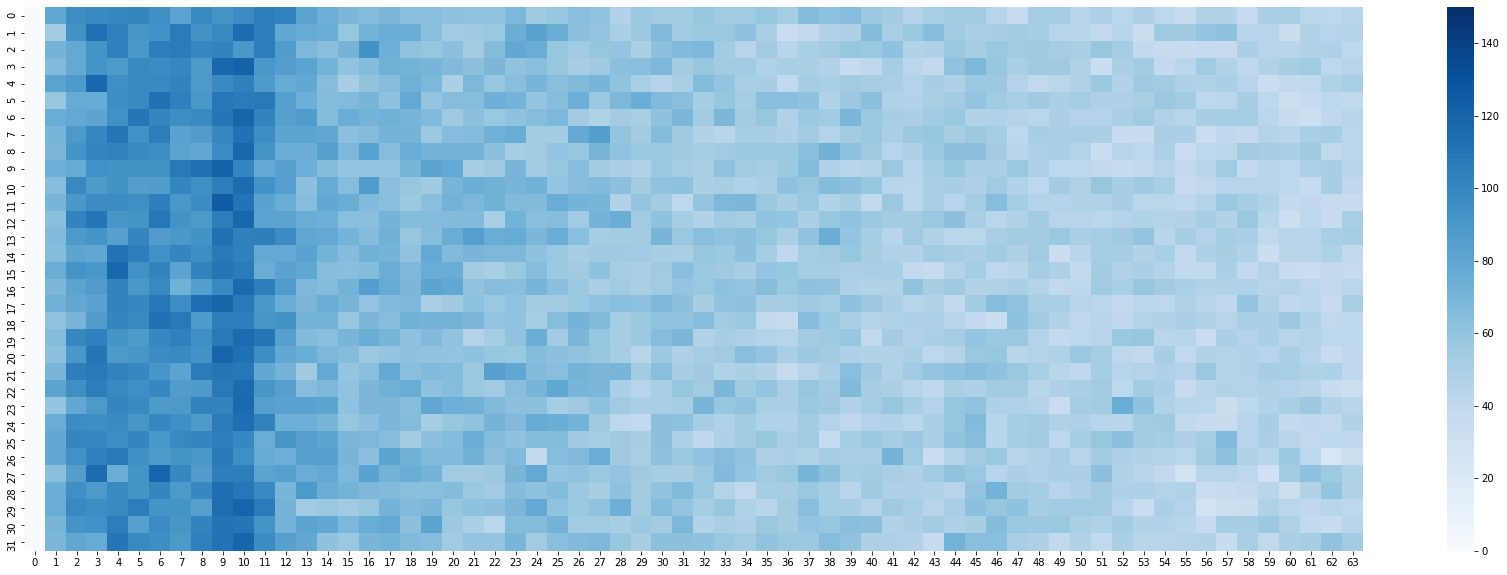

In [115]:
plt.figure(figsize=(30, 10))
sns.heatmap(hm2, cmap='Blues',vmin=0, vmax=150)

In [121]:
percentages = []
for i in range(10):
    print(f'\n\nexp {i+1}')
    percentage , mask_counts, token_counts, mask_hits = run_exp_masking_percentage(data_loader=imp_data_loader_span_mlm_dummy)
    percentages.append(percentage)
    
percentages_df = pd.Series(percentages)
percentages_df.describe()



exp 1
total_mask_tokens: 1481970
total_tokens: 10160000
masking percentage: 14.586


exp 2
total_mask_tokens: 1481245
total_tokens: 10160000
masking percentage: 14.579


exp 3
total_mask_tokens: 1480263
total_tokens: 10160000
masking percentage: 14.570


exp 4
total_mask_tokens: 1481745
total_tokens: 10160000
masking percentage: 14.584


exp 5
total_mask_tokens: 1481663
total_tokens: 10160000
masking percentage: 14.583


exp 6
total_mask_tokens: 1481224
total_tokens: 10160000
masking percentage: 14.579


exp 7
total_mask_tokens: 1481205
total_tokens: 10160000
masking percentage: 14.579


exp 8
total_mask_tokens: 1480828
total_tokens: 10160000
masking percentage: 14.575


exp 9
total_mask_tokens: 1481625
total_tokens: 10160000
masking percentage: 14.583


exp 10
total_mask_tokens: 1480678
total_tokens: 10160000
masking percentage: 14.574


count    10.000000
mean     14.579179
std       0.005246
min      14.569518
25%      14.576006
50%      14.579080
75%      14.583204
max      14.586319
dtype: float64

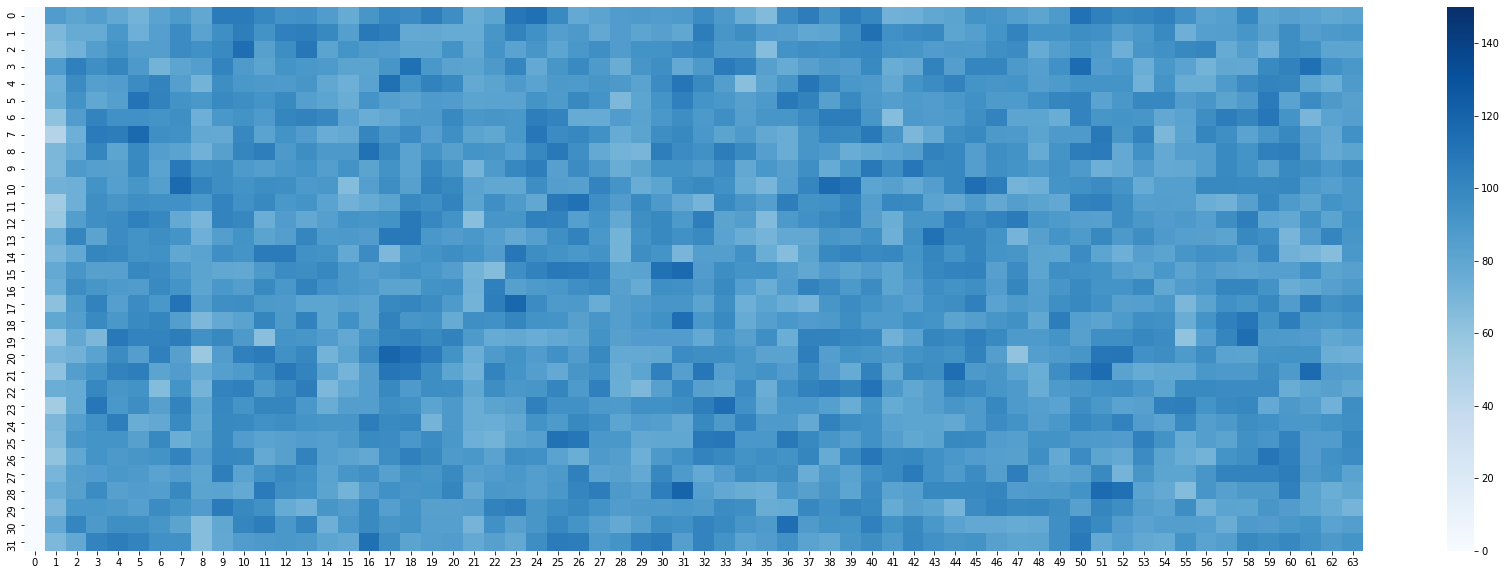

In [122]:
hm2_dummy = construct_heatmap(mask_hits, bz=32, seq_len=64, col_normalize=False)
plt.figure(figsize=(30, 10))
sns.heatmap(hm2_dummy, cmap='Blues',vmin=0, vmax=150)

In [352]:
percentages = []
for i in range(1):
    print(f'\n\nexp {i+1}')
    percentage , mask_counts, token_counts, mask_hits = run_exp_masking_percentage(data_loader=data_loader_span_mlm)
    percentages.append(percentage)
    
percentages_df = pd.Series(percentages)
percentages_df.describe()



exp 1
total_mask_tokens: 763040
total_tokens: 5100320
masking percentage: 14.961


count     1.00000
mean     14.96063
std           NaN
min      14.96063
25%      14.96063
50%      14.96063
75%      14.96063
max      14.96063
dtype: float64

In [353]:
len(mask_hits)

763040

In [354]:
hm3 = construct_heatmap(mask_hits, bz=32, seq_len=64, col_normalize=False)

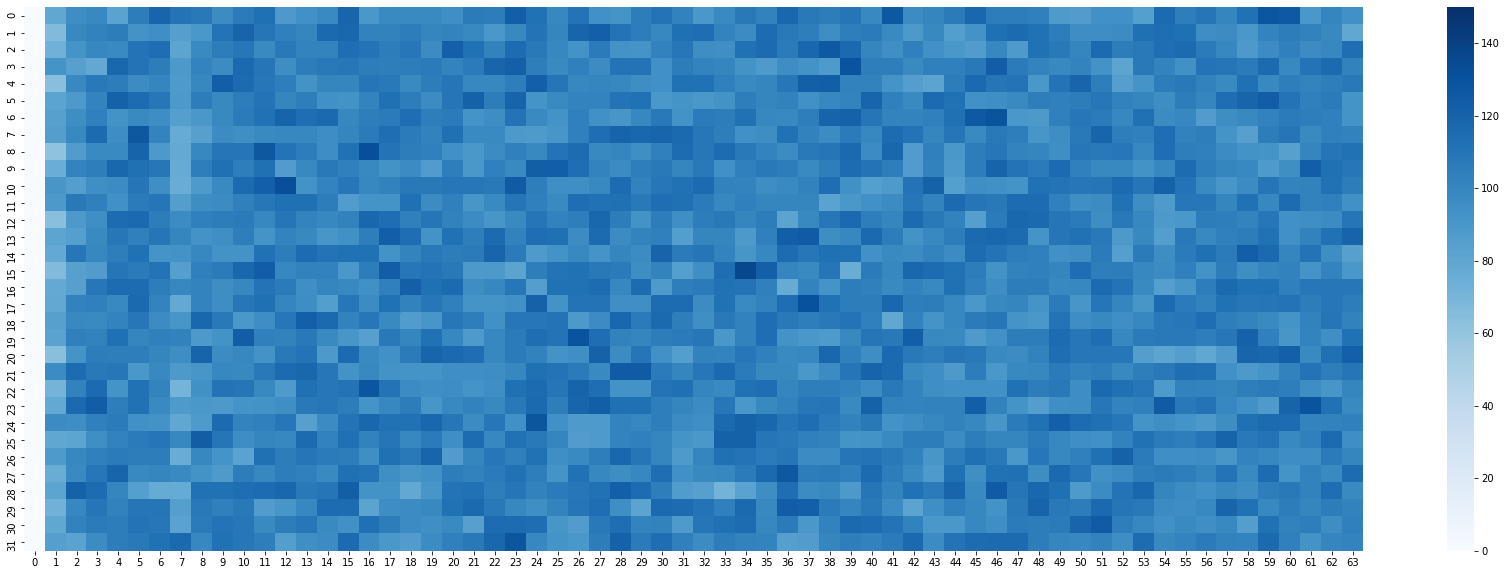

In [358]:
plt.figure(figsize=(30, 10))
sns.heatmap(hm3, cmap='Blues',vmin=0, vmax=150)

In [273]:
hm23_diff = np.abs(hm2 -  hm3)

In [278]:
np.max(hm23_diff)

42.0

In [268]:
def normalize_hm(heat_map, bz, seq_len):
    _heat_map = copy.deepcopy(heat_map)
    for i in range(seq_len):
    #             std, mean = np.mean(heat_map[:,i]), np.std(heat_map[:,i])
        total = np.sum(_heat_map[:,i])
        for j in range(bz):
            _heat_map[j, i] = (_heat_map[j, i]) / total
    return _heat_map

In [269]:
# hm23_diff_norm = normalize_hm(hm23_diff, bz=32, seq_len=64)

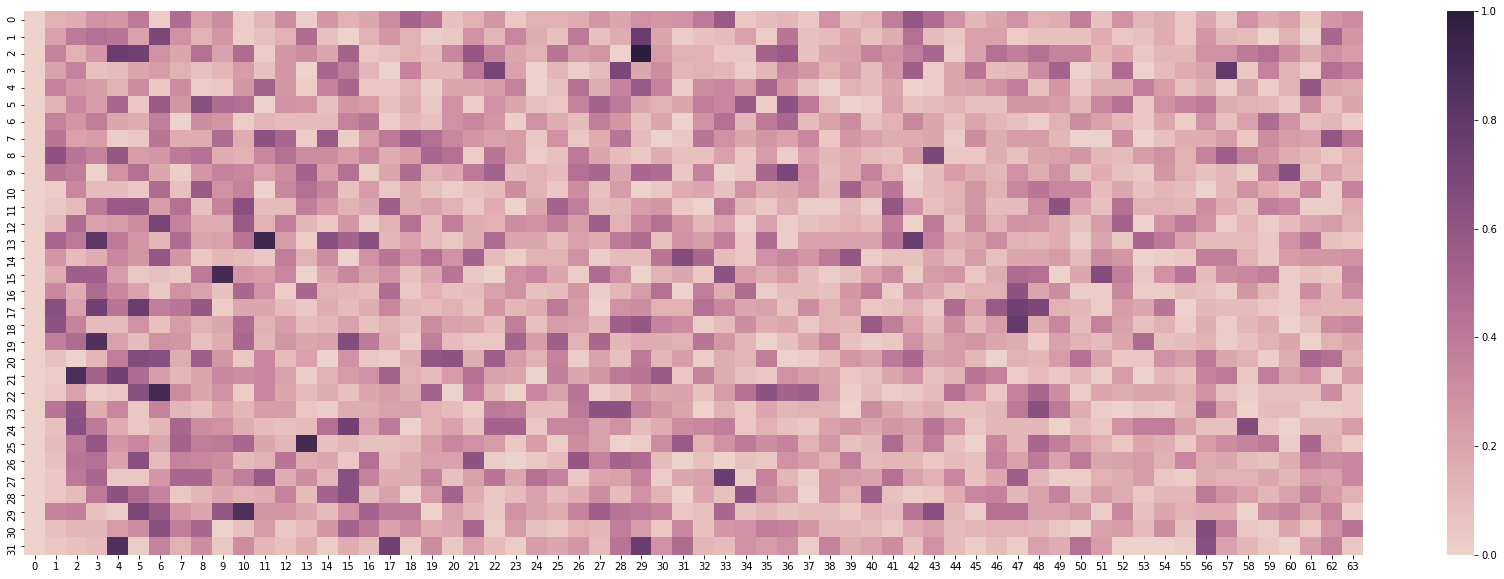

In [279]:
plt.figure(figsize=(30, 10))
sns.heatmap(hm23_diff/42, cmap=sns.cubehelix_palette(as_cmap=True))

In [271]:
# plt.figure(figsize=(30, 10))
# sns.heatmap(hm23_diff_norm, cmap='Blues', vmin=0, vmax=.3)

### Results

The following result include \<s\> and \</s\> in `total_tokens ` 

---
    
mean n gram size = 3

percentage = 9.69834570838335

--

mean n gram size = 2

percentage = 19.38757835872014


--

n gram size = choice(n) change over time it computed

percentage = 16.58890391638196


However this approach each chunk will have the same span size (e.g. all sequence in te first chunk wil have 1-token span in that batch)

-- 

mask_window = math.ceil(1/mlm_prob)

n gram size = choice(n) change over time it computed

percentage = 14.463811201577826

-- 

mask_window = float(1/mlm_prob)

ctx_window = torch.round(n * mask_window)

n gram size = choice(n) change over time it computed

percentage = 14.949700144179442




